To simulate a chromosome we need the tile thresholds/cutoffs from the original chromosome, the learned interaction strength maps from the same, and then thats everything we need to use the epigenetic signals for the new chromosome or cell type.


filename = "{0}-small:{1}-actual:{2}-{3}".format(celltype,small_resolution,resolution,"wgtiles")
HCT116-untreated-small:5000-actual:25000-wgtiles

mapfileoutname = "{0}-{1}kb-chr{2}-{3}-learnedmaps.csv".format(celltype,resolution//1000,chrnames[chrindex],signame)
HCT116-untreated-25kb-chr2-Gro-tiles-learnedmaps.csv

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

figfold = "figure5"

sizefile = "/Zulu/mike/armsizes.txt"
celltype = "KC"
hic_directory = "/Zulu/mike/dumped-hic/KC/"
hic_prefix = "Kc167_combo_q30_KR"
mapcelltype = "KC"

resolution = 10000
small_resolution = 10000
distance_min = 0#5000000
distance_min_bins = int(distance_min/resolution)
distance_max = 200000000
distance_max_bins = int(distance_max/resolution)
chrstart = 0
chrstop = 2
mapindex = 1
#signal files
#signal names
#filenames = ["S2_1kb_groseq.bw","H3K27ac.bw","H3K27me3.bw","Kc_H3K9me3.bw"]
#names = ["Gro","H3K27ac","H3K27me3","H3K9me3"]
filenames = ["H3K27ac.bw","H3K27me3.bw","Kc_H3K9me3.bw"]
names = ["H3K27ac","H3K27me3","H3K9me3"]
comp_num = len(filenames)
chrpairs = [[0,1],[2,3]]
chrnames = ['2L','2R','3L','3R']
newnames = ['2L+R','3L+R']

male = False


In [3]:
sizes = open(sizefile,'r')

chrnames = []
chrsizes = []
for line in sizes:
    li = line.split()
    if li[0] == 'Y' or li[0] == 'MT':
        continue
    chrnames.append(li[0][4:])
    chrsizes.append(int(li[1]))

sizes.close()

print(chrnames)

['2L', '2R', '3L', '3R', '4', 'X', 'Y']


In [4]:
import math
#determine size of each chromosome in bins:
chrsizebins = []

for i in range(len(chrnames)):
    s = int(math.ceil(chrsizes[i]/resolution + 1))
    chrsizebins.append(s)
    
totalsize = sum(chrsizebins)
print(totalsize)
print(chrsizebins)

13765
[2353, 2530, 2813, 3209, 136, 2356, 368]


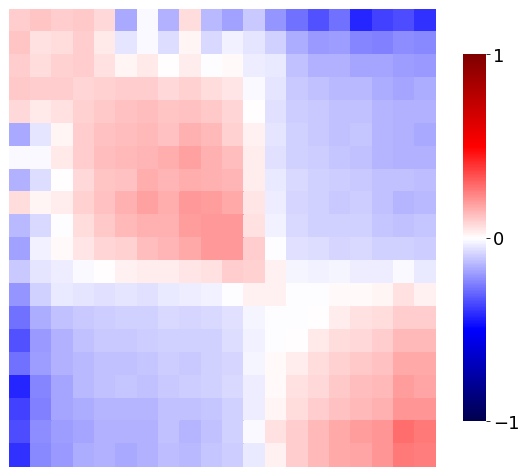

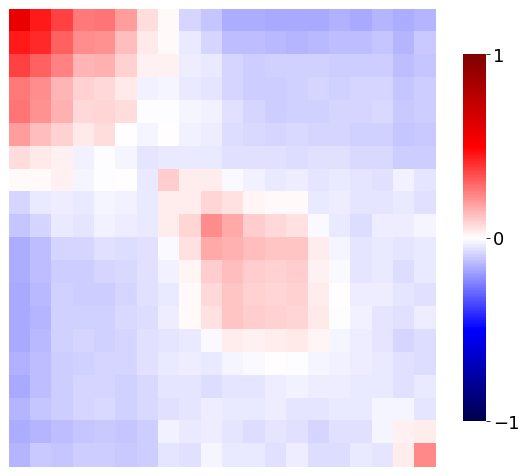

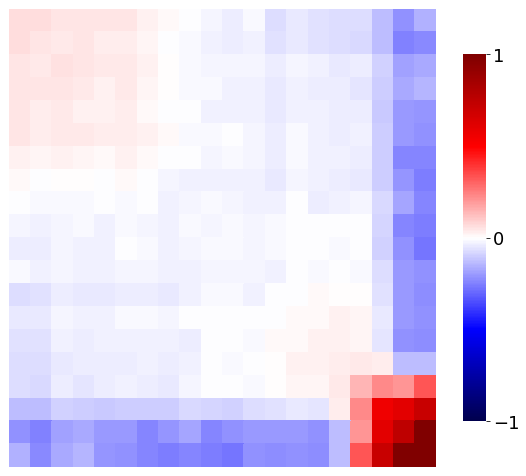

/Zulu/mike/learneddistances/KC-10kb-chr2L+R-distances-min:max-0kb:2000kb.csv
/Zulu/mike/learneddistances/KC-10kb-chr3L+R-distances-min:max-0kb:2000kb.csv
3209
3209


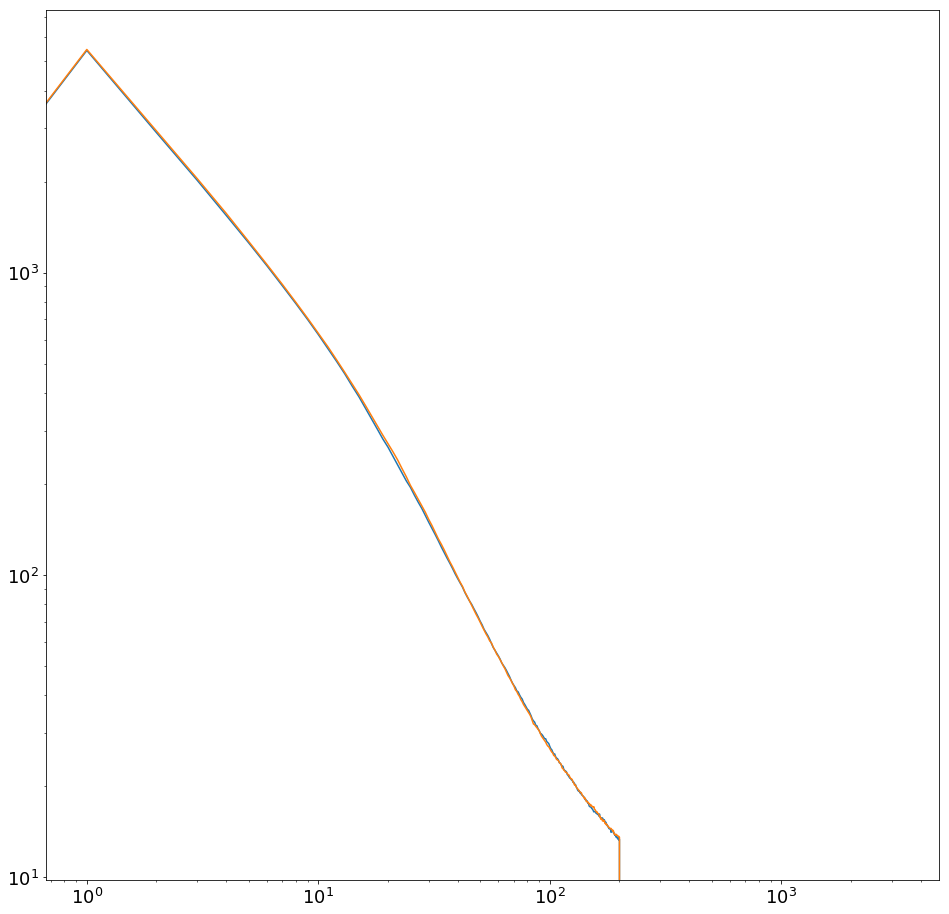

In [37]:
#load in tiles:
filename = "/Zulu/mike/{0}-small:{1}-actual:{2}-{3}".format(celltype,small_resolution,resolution,"wgtiles")

wg_quantiles = pd.read_csv(filename)
#print(wg_quantiles)

tiles = wg_quantiles.shape[0]

mappings = []
mapnames = []
for chrindex in range(chrstart,chrstop):
    mappings.append([])
    for signame in names:
        mapfileinname = "/Zulu/mike/learnedmaps/{0}-{1}kb-chr{2}-{3}-tiles-learnedmaps-min:max-{4}kb:{5}kb.csv".format(celltype,resolution//1000,newnames[chrindex],signame,distance_min//1000,2000000//1000)
        mappings[-1].append(pd.read_csv(mapfileinname))
        #print(mapfileinname)

for signame in names:
    mapnames.append(signame+"-tiles")
        
#load in mappings:
ignored = []
for chrindex in range(chrstart,chrstop):
    #load in ignored
    ignorefileinname = "/Zulu/mike/learnedignores/{0}-{1}kb-chr{2}-ignore.csv".format(celltype,resolution//1000,newnames[chrindex])
    #ignorefileinname = "{0}-{1}kb-chr{2}-ignore.csv".format(celltype,resolution//1000,chrnames[chrindex])

    ignored.append(pd.read_csv(ignorefileinname))
    
    
averagemaps = []
for mapindex in range(len(names)):
    averagemaps.append(mappings[chrstart][mapindex])

for mapindex in range(len(names)):
    for chrindex in range(chrstart+1,chrstop):
        averagemaps[mapindex] = averagemaps[mapindex].add(mappings[chrindex][mapindex],fill_value=0)
        
for mapindex in range(len(names)):
    averagemaps[mapindex] = averagemaps[mapindex]/(chrstop-chrstart)

for m,n in zip(averagemaps,names):
    fig, ax = plt.subplots(figsize=(8,7))
    sns.heatmap(m,cmap='seismic',xticklabels=False,yticklabels=False,annot=False,center=0,vmin=-1,vmax=1,
               cbar_kws = dict(use_gridspec=True,ticks=[-1,0,1],shrink=0.8,aspect=16))
    ax.xaxis.tick_top()
    plt.tight_layout()
    ax.tick_params(length=0)
    #plt.title("Average "+n)
    plt.savefig("/Zulu/mike/figures/{0}/{1}-{2}kb-average-{3}mapheatmap.svg".format(figfold,mapcelltype,resolution//1000,n),format='svg')
    plt.show()
    
#for m,n in zip(mappings,names):
#    fig, ax = plt.subplots(figsize=(8,7))
#    sns.heatmap(m,cmap='seismic',annot=False,center=0,vmin=-1,vmax=1)
#    ax.xaxis.tick_top()
#    plt.tight_layout()
#    ax.tick_params(length=0)
#    plt.title(n)
#    plt.savefig("./figures/{0}-{1}kb-chr{2}-{3}mapheatmap.png".format(mapcelltype,resolution//1000,chrnames[mapindex],n),format='png')
#    plt.show()
#    #sns.heatmap(m, center=0, vmin =-1,vmax=1, cmap="seismic")
#    #plt.title(n)
#    #plt.show()
    
#now load in dists from the right celltype
distances = []
for chrindex in range(chrstart,chrstop):
    distancefileinname = "/Zulu/mike/learneddistances/{0}-{1}kb-chr{2}-distances-min:max-{3}kb:{4}kb.csv".format(celltype,resolution//1000,newnames[chrindex],distance_min//1000,2000000//1000)
    print(distancefileinname)
    distances.append(pd.read_csv(distancefileinname))
    
    
#print(distances)
for d in distances:
    print(len(d))
    plt.plot(d)
plt.yscale('log')
plt.xscale('log')
plt.show()
    


In [6]:
import pandas as pd
import pyBigWig
import math
from os.path import commonprefix

#small_resolution = 100000
resolution_ratio = resolution//small_resolution


print(filenames)
#filenames = ["hct116-H3K9me3-ENCFF402WZH.bigWig","hct116-H3K27me3-ENCFF030SYQ.bigWig","hct116-H3K27ac-ENCFF225QAB.bigWig"]
#names = ["H3K9me3","H3K27me3","H3K27ac"]
bigwig_medi_dfs = []
bigwig_mean_dfs = []
#lets make a pandas dataframe
for pair in chrpairs:
    chrom1 = chrnames[pair[0]]
    chrom2 = chrnames[pair[1]]
    print(chrom1)
    print(chrom2)
    medi_dic = {}
    mean_dic = {}
    lastlength = 0
    for name,filen in zip(names,filenames):
        #print("Reading in: {0}".format(name))
        try:
            bw = pyBigWig.open("/Zulu/mike/chips/"+filen)
        except RuntimeError:
            print("Trouble opening {0}".format(filen))
        print(bw.chroms())
        prefix = commonprefix(bw.chroms().keys())
        #print(prefix)
        #calculate number of 25kb bins
        #chromlength = bw.chroms(prefix+chrom)
        chrom1length = bw.chroms(prefix+chrom1)
        chrom2length = bw.chroms(prefix+chrom2)
        totallength = chrom1length+chrom2length
        #print(chromlength)
        #binnum = int(math.ceil(chromlength/small_resolution))
        binnum = int(math.ceil(totallength/small_resolution))
        smalls1 = bw.stats(prefix+chrom1,nBins=math.ceil(chrom1length/small_resolution))
        smalls2 = bw.stats(prefix+chrom2,nBins=math.ceil(chrom2length/small_resolution))
        #print(binnum)
        #smalls = bw.stats(prefix+chrom,nBins=binnum)
        
        both_smalls = smalls1 + smalls2
        print(len(both_smalls))
        medi_vals = []
        mean_vals = []
        for pos in range(resolution_ratio,binnum,resolution_ratio):
            chunk = np.array(both_smalls[pos-resolution_ratio:pos], dtype=np.float)
            try:
                medi_vals.append(np.median(chunk))
                mean_vals.append(np.mean(chunk))
            except TypeError:
                print(chunk)
        
        #print(chromlength)
        #print(binnum)
        #print(len(vals))
        #x = small_resolution
        #vals = []
        #while x < chromlength:
            #print(x)
            #vals.extend(bw.stats(prefix+chrom,x-small_resolution,x))
            #x += small_resolution
        #vals.extend(bw.stats(prefix+chrom,x-small_resolution,chromlength))
        #print(bw.stats("chr"+chrom,x-resolution,chromlength))
        #vals.extend([0,0,0,0,0])
        medi_vals.extend([0,0,0,0,0])
        mean_vals.extend([0,0,0,0,0])
        
        if lastlength:
            medi_vals.extend([0,0,0,0,0,0,0,0,0,0,0,0,0,0])
            medi_vals = medi_vals[:lastlength]
            mean_vals.extend([0,0,0,0,0,0,0,0,0,0,0,0,0,0])
            mean_vals = mean_vals[:lastlength]
        lastlength = len(medi_vals)
        #print(len(vals))
        #print(vals[:10])
        medi_dic[name] = medi_vals
        mean_dic[name] = mean_vals
        
    
    bigwig_medi_dfs.append(pd.DataFrame(data=medi_dic).fillna(0))
    bigwig_mean_dfs.append(pd.DataFrame(data=mean_dic).fillna(0))
    
for df in bigwig_mean_dfs:
    print(df.shape)


['H3K27ac.bw', 'H3K27me3.bw', 'Kc_H3K9me3.bw']
2L
2R
{'chrM': 20000, 'chr3L': 28110227, 'chrY': 3667352, 'chr4': 1348131, 'chr2R': 25286936, 'chr2L': 23513712, 'chr3R': 32079331, 'chrX': 23542271}
4881


/Zulu/mike/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


{'chrM': 20000, 'chr3L': 28110227, 'chrY': 3667352, 'chr4': 1348131, 'chr2R': 25286936, 'chr2L': 23513712, 'chr3R': 32079331, 'chrX': 23542271}
4881
{'arm_2L': 23513712, 'arm_2R': 25286936, 'arm_X': 23542271, 'arm_3R': 32079331, 'arm_3L': 28110227, 'arm_4': 1348131}
4881
3L
3R
{'chrM': 20000, 'chr3L': 28110227, 'chrY': 3667352, 'chr4': 1348131, 'chr2R': 25286936, 'chr2L': 23513712, 'chr3R': 32079331, 'chrX': 23542271}
6020
{'chrM': 20000, 'chr3L': 28110227, 'chrY': 3667352, 'chr4': 1348131, 'chr2R': 25286936, 'chr2L': 23513712, 'chr3R': 32079331, 'chrX': 23542271}
6020
{'arm_2L': 23513712, 'arm_2R': 25286936, 'arm_X': 23542271, 'arm_3R': 32079331, 'arm_3L': 28110227, 'arm_4': 1348131}
6020
(4885, 3)
(6023, 3)


In [7]:
#ehre we need to double every signal on the X chromosome

if male == True:
    xindex = chrnames.index('X')
    print(xindex)
    print(bigwig_mean_dfs[xindex])
    bigwig_mean_dfs[xindex] = bigwig_mean_dfs[xindex] * 2
    print(bigwig_mean_dfs[xindex])

In [8]:
#now we convert to quantiles
signames = []
for x in range(len(bigwig_mean_dfs)):
    print(bigwig_mean_dfs[x].shape)
    newcolumns = []
    for column in bigwig_mean_dfs[x].iloc[:,-comp_num:]:
        #print(df[column])
        #print(q[column])
        
        newcolumns.append([])
        for r in bigwig_mean_dfs[x][column]:
            place = wg_quantiles[column].searchsorted(r)-1#[0]
            newcolumns[-1].append(place)
        
    for index,column in enumerate(bigwig_mean_dfs[x].iloc[:,:comp_num]):
        bigwig_mean_dfs[x][column+"-tiles"] = pd.Series(newcolumns[index],dtype='int16')
        signames.append(column+"-tiles")
        
for df in bigwig_mean_dfs:
    print(df.shape)

(4885, 3)
(6023, 3)
(4885, 6)
(6023, 6)


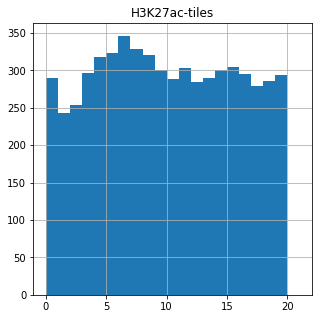

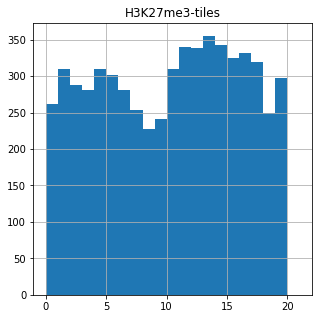

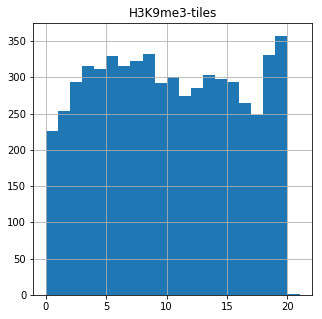

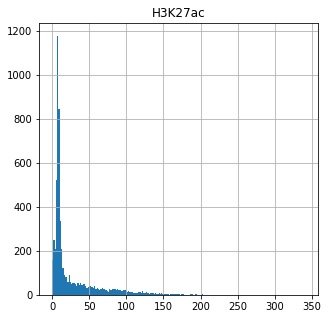

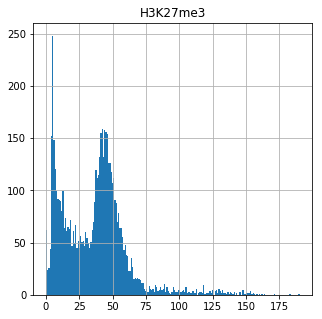

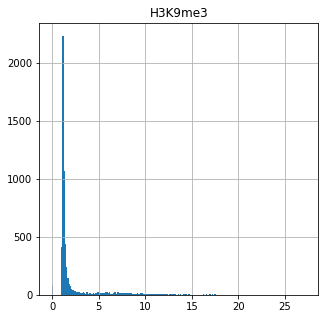

In [9]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (5,5)
for col in bigwig_mean_dfs[0].iloc[:,-comp_num:]:
    df.hist(col,bins=range(tiles+1))
    plt.show()
    
for col in bigwig_mean_dfs[0].iloc[:,:comp_num]:
    df.hist(col,bins=200)
    plt.show()

In [10]:
print(len(bigwig_mean_dfs))
print(len(ignored))

for df in bigwig_mean_dfs:
    print(df.columns)
    print(df.shape)

2
2
Index(['H3K27ac', 'H3K27me3', 'H3K9me3', 'H3K27ac-tiles', 'H3K27me3-tiles',
       'H3K9me3-tiles'],
      dtype='object')
(4885, 6)
Index(['H3K27ac', 'H3K27me3', 'H3K9me3', 'H3K27ac-tiles', 'H3K27me3-tiles',
       'H3K9me3-tiles'],
      dtype='object')
(6023, 6)


In [11]:
for x in range(len(bigwig_mean_dfs)):
    print(x)
    print(len(ignored[x]))
    #print(z_embed_df)
    print(bigwig_mean_dfs[x].shape)

    #shorten to match ignorebins length
    bigwig_mean_dfs[x] = bigwig_mean_dfs[x].drop(bigwig_mean_dfs[x].index[len(ignored[x]):])

    print(bigwig_mean_dfs[x].shape)
    
    #here we don't want to shorten, we just want to replace with nans
    #so we don't even need to do that here, we can do it later.
    #nan_ignore_matrix[ignorebins,:] = np.nan
    #nan_ignore_matrix[:,ignorebins] = np.nan
    
    
    #bigwig_mean_df_cc = bigwig_mean_df[~np.array(ignorebins)]

    #bigwig_mean_df_cc.reset_index(inplace=True)

    #print(bigwig_mean_df_cc)

    #mean_df =  pd.DataFrame(bigwig_mean_df_cc)

    #print(mean_df)

0
4883
(4885, 6)
(4883, 6)
1
6022
(6023, 6)
(6022, 6)


In [12]:
def averagemaps(mappings,names):
    averagemaps = []
    for nameindex in range(len(names)):
        averagemaps.append(mappings[0][nameindex])

    for nameindex in range(len(names)):
        for mapset in mappings[1:]:
            averagemaps[nameindex] = averagemaps[nameindex].add(mapset[nameindex])

    for nameindex in range(len(names)):
        averagemaps[nameindex] = averagemaps[nameindex]/(len(mappings))
        
    return averagemaps

In [13]:
def mapping(maps,sig1,sig2):
    total = 1
    for m,i,j in zip(maps,sig1,sig2):
        try:
            total += m.at[i,str(j)]
        except KeyError:
            return np.nan
    return total

Loading: 2L vs 2R
Size: 4883
2353
Size: 4883


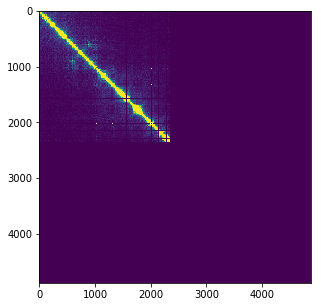

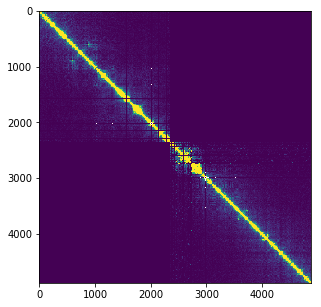

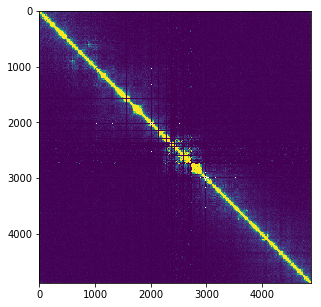

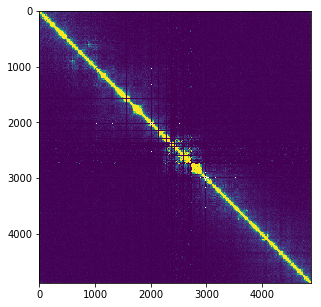

Loading: 3L vs 3R
Size: 6022
2813
Size: 6022


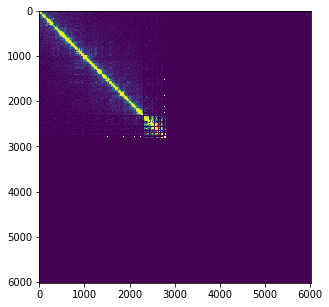

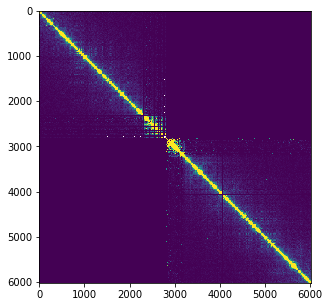

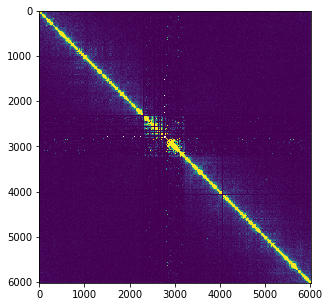

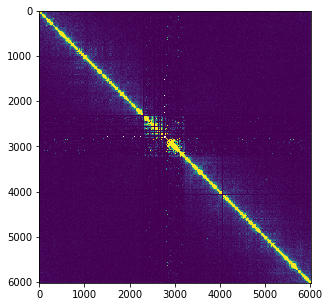

In [14]:
observeds=[]
for x in range(len(chrpairs)):
    pair = chrpairs[x]
    chrom1 = chrnames[pair[0]]
    chrom2 = chrnames[pair[1]]
    sizebins = len(ignored[x])
    print("Loading: {0} vs {1}".format(chrom1,chrom2))
    print("Size: {0}".format(sizebins))
    print(chrsizebins[pair[0]])
    
    interactions1 = open(hic_directory+hic_prefix+"arm_"+chrom1+"_"+"arm_"+chrom1+"_"+str(resolution)+".txt",'r')
    interactions12 = open(hic_directory+hic_prefix+"arm_"+chrom1+"_"+"arm_"+chrom2+"_"+str(resolution)+".txt",'r')
    interactions2 = open(hic_directory+hic_prefix+"arm_"+chrom2+"_"+"arm_"+chrom2+"_"+str(resolution)+".txt",'r')
    
    matrix = np.zeros((sizebins,sizebins))
    print("Size: {0}".format(sizebins))
    
    #let's make each chromosome, normalize it, then add it to the big one.
    for line in interactions1:
        li = line.split()
        left = int(li[0])//resolution
        right = int(li[1])//resolution
        KRscore = float(li[2])
        matrix[left][right] = KRscore
        matrix[right][left] = KRscore
    
    plt.imshow(matrix,vmin = 0,vmax=100)
    plt.show()
        
    for line in interactions2:
        li = line.split()
        left = int(li[0])//resolution + chrsizebins[pair[0]]
        right = int(li[1])//resolution + chrsizebins[pair[0]]
        KRscore = float(li[2])
        matrix[left][right] = KRscore
        matrix[right][left] = KRscore
    
    plt.imshow(matrix,vmin = 0,vmax=100)
    plt.show()
        
    for line in interactions12:
        li = line.split()
        left = int(li[0])//resolution
        right = int(li[1])//resolution + chrsizebins[pair[0]]
        KRscore = float(li[2])
        matrix[left][right] = KRscore
        matrix[right][left] = KRscore
        
    plt.imshow(matrix,vmin = 0,vmax=100)
    plt.show()
        
        
    interactions1.close()
    interactions12.close()
    interactions2.close()
    observeds.append(np.copy(matrix))
    plt.imshow(observeds[-1],vmin = 0,vmax=100)
    plt.show()

In [15]:
print(len(observeds))
#plt.imshow(observeds[-1],vmin = 0,vmax=100)
#plt.show()

2


In [16]:
#here I want to test obs/exp using the actual dists vs the adjusted dists
#for chrindex in range(chrstart,chrstop):
#    o = observeds[chrindex]
#    for d in range(len(o)):
#        np.mean(np.diag(o,k=d)
        


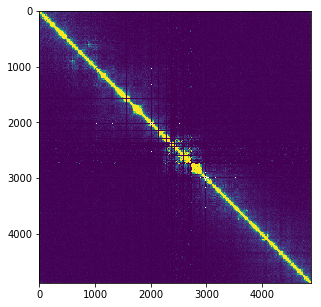

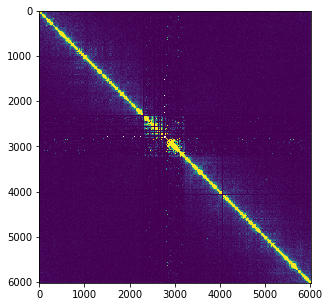

In [17]:
plt.imshow(observeds[0],vmin = 0,vmax=100)
plt.show()
plt.imshow(observeds[1],vmin = 0,vmax=100)
plt.show()

In [18]:

import math
import matplotlib
import matplotlib.gridspec as grd
matplotlib.rcParams['figure.figsize'] = (16,16)

import matplotlib.gridspec as grd
from matplotlib.colors import LinearSegmentedColormap
#create a juicebox-like red to white colormap
br = LinearSegmentedColormap.from_list("bright_red",[(1,1,1),(1,0,0)])

from scipy import stats

expecteds = []
distonlys = []
individuals = []

for x in range(len(chrpairs)):
    pair = chrpairs[x]
    sizebins = len(ignored[x])
    print(sizebins)
    chrom = newnames[x]
    print("Loading: {0} vs {1}".format(chrom,chrom))
    
    maps = averagemaps(mappings[:chrindex]+mappings[chrindex+1:],names)
    #dists = distances[corrindex]
    dists = distances[x]
    #print(dists)
    sigs = np.array(bigwig_mean_dfs[x][mapnames])
    print(len(sigs))
    print(sizebins)
    ignor = ignored[x]
    #print(mappings)
    #print(sigs.dtype)
    
    observed = observeds[x]
    expected = np.zeros((sizebins,sizebins))
    distonly = np.zeros((sizebins,sizebins))
    indivs = []
    for n in range(comp_num):
        indivs.append(np.zeros((sizebins,sizebins)))
    for i in range(0,sizebins):
        #print(i)
        for j in range(min(i,sizebins),sizebins):
            #print(ignor.at[i,'0'])
            if ignor.at[i,'0'] or ignor.at[j,'0']:
                if ignor.at[i,'0']:
                    observed[i,:] = np.nan
                    expected[i,:] = np.nan
                if ignor.at[j,'0']:
                    observed[:,j] = np.nan
                    expected[:,j] = np.nan
                continue
            #distindex = distance_indices[j-i]
            if j-i >= dists.shape[0]:
                #observed[i,j] = np.nan
                expected[i,j] = np.nan
                expected[j,i] = np.nan
                continue                
            distfactor = dists.iloc[j-i,0]
            #expected[i,j] = np.random.poisson(max(0,bias[i]*bias[j]*distfactor*ncomp_scales_term(comps[i],comps[j],scalefactors)))
            #print(maps)
            #print(sigs[i])
            #print(sigs[j])
            e = distfactor*mapping(maps,sigs[i],sigs[j])
            #if math.isnan(e):
            #    print('ij')
            #    print(i)
            #    print(j)
            #    print('sigs')
            #    print(sigs[i])
            #    print(sigs[j])
            #    print('maps')
            #    print(maps)
                
            expected[i,j] = e
            #expected[i,j] = np.random.poisson(max(0,distfactor*mapping(maps,sigs[i],sigs[j])))
            #expected[i,j] = -1 + mapping(maps[csig:csig+1],sigs[i][0:csig]+sigs[i][csig+1:cnum],sigs[j][0:csig]+sigs[j][csig+1:cnum])
            #expected[i,j] = math.log(distfactor)

            expected[j,i] = observed[i,j]
            
            distonly[i,j] = distfactor*1
            distonly[j,i] = observed[i,j]
            
            for c in range(comp_num):
                indivs[c][i,j] = distfactor*mapping([maps[c]],[sigs[i][c]],[sigs[j][c]])
                indivs[c][j,i] = observed[i,j]
            
    
    expecteds.append(np.copy(expected))
    distonlys.append(np.copy(distonly))
    individuals.append([np.copy(i) for i in indivs])

4883
Loading: 2L+R vs 2L+R
4883
4883
6022
Loading: 3L+R vs 3L+R
6022
6022


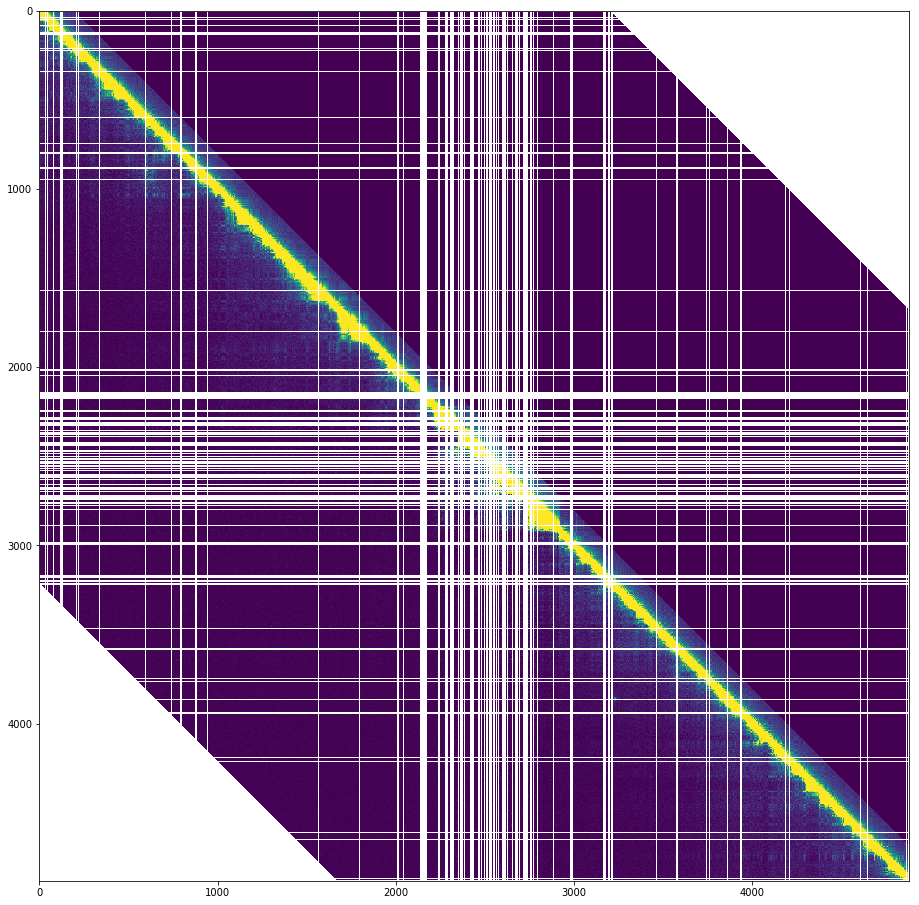

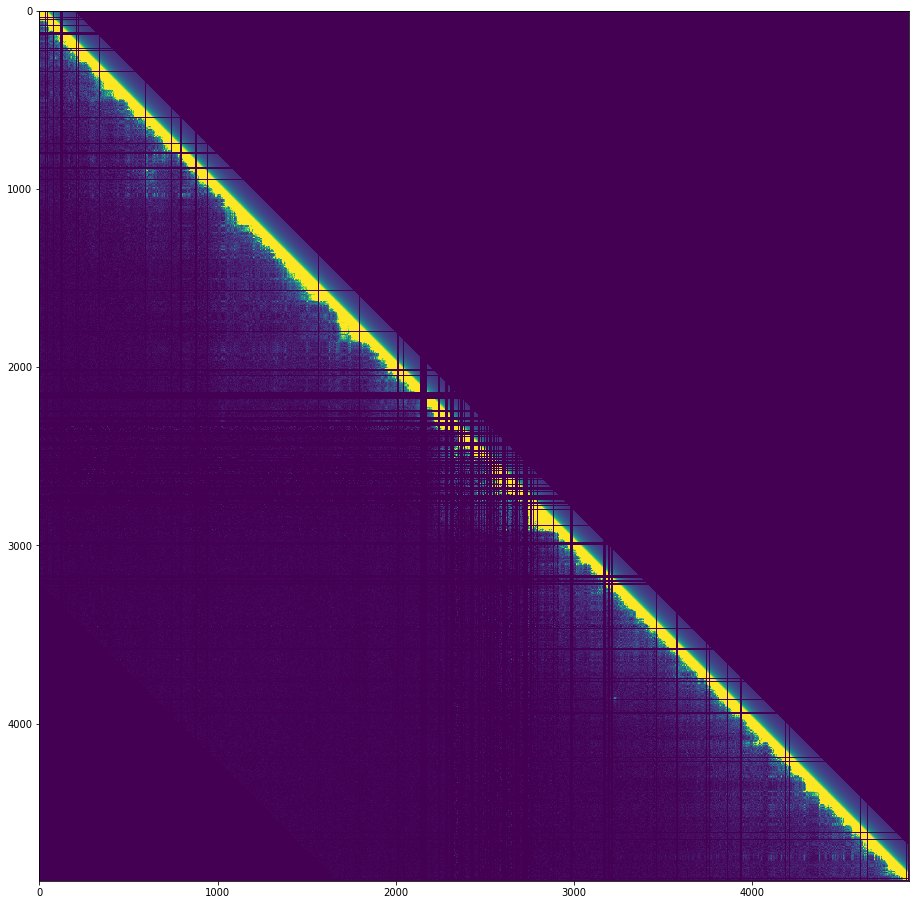

In [19]:
plt.imshow(expecteds[0],vmin = 0,vmax=100)
plt.show()
plt.imshow(distonlys[0],vmin = 0,vmax=100)
plt.show()

/Zulu/mike/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
/Zulu/mike/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:509: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


500
680
544
736
600
800
[50, 144]
['6 Mb', '7 Mb']


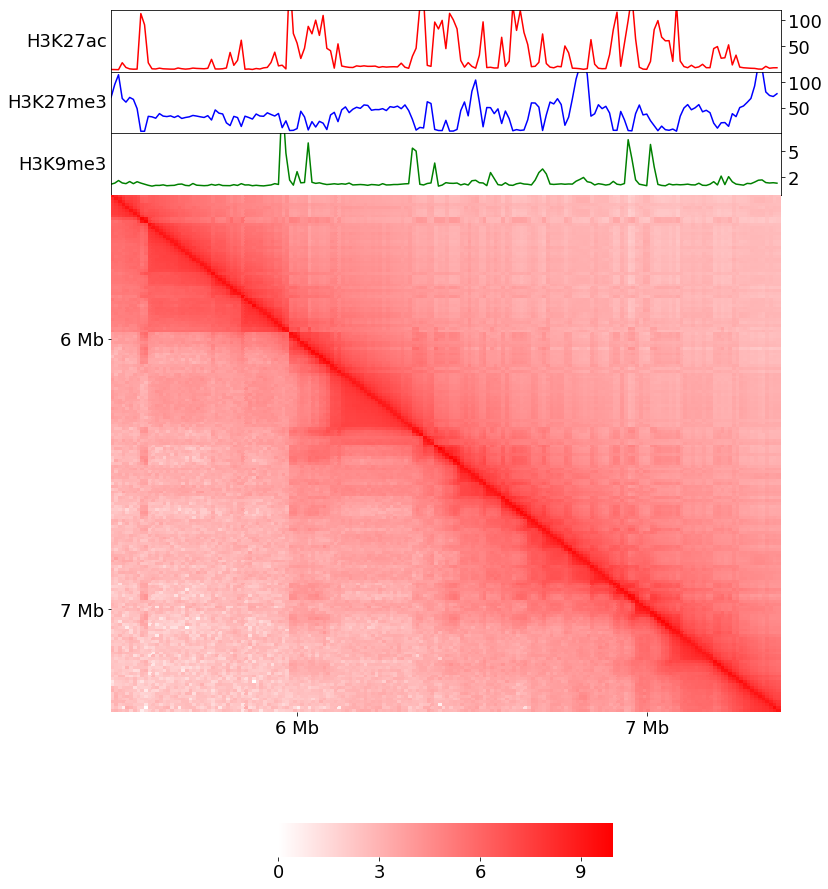

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:2413: RuntimeWarning: Mean of empty slice
  mns = np.nanmean(a=a, axis=axis, keepdims=True)
/Zulu/mike/.local/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:2416: RuntimeWarning: Mean of empty slice.
  mns = a.mean(axis=axis, keepdims=True)
/Zulu/mike/.local/lib/python3.5/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Zulu/mike/.local/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Zulu/mike/.local/lib/python3.5/site-packages/numpy/core/_methods.py:105: R

          Expected  Observed
Expected  1.000000  0.898745
Observed  0.898745  1.000000
            Expected-Z  Observed-Z
Expected-Z    1.000000    0.418413
Observed-Z    0.418413    1.000000
               Distance Only  Observed
Distance Only       1.000000  0.932072
Observed            0.932072  1.000000
500
680
544
735
600
800
[55, 145]
['6 Mb', '7 Mb']


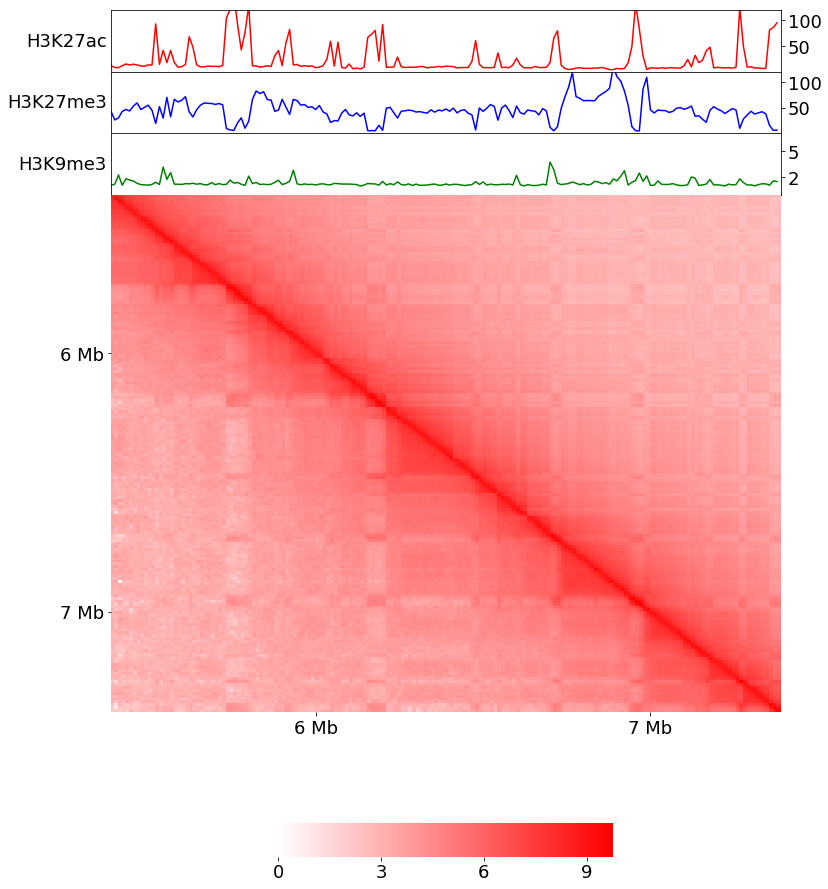

          Expected  Observed
Expected  1.000000  0.902729
Observed  0.902729  1.000000
            Expected-Z  Observed-Z
Expected-Z    1.000000    0.329489
Observed-Z    0.329489    1.000000
               Distance Only  Observed
Distance Only       1.000000  0.935473
Observed            0.935473  1.000000


In [38]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 0.0),  # transparent white   with alpha = 30%
    #"axes.facecolor":    (0.0, 1.0, 0.0, 0.5),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 0.0),  # blue  with alpha = 20%
})

from scipy.ndimage.filters import gaussian_filter
import sklearn.metrics
import scipy.stats

from matplotlib.colors import LinearSegmentedColormap
#create a juicebox-like red to white colormap
br = LinearSegmentedColormap.from_list("bright_red",[(1,1,1),(1,0,0)])

correlationout= "/Zulu/mike/accuracy/{0}:mappedwith-{1}-avgallbutself:{2}kb-pearson.txt".format(celltype,
                                                                               mapcelltype,resolution//1000)
corrout = open(correlationout,'w')
corrout.write("\t".join(["Chr","Correlation","Z-Correlation","Distance Correlation"])+"\n")
#chrstart=3

left = int((5*1000000)/resolution)
right = int((6.8*1000000)/resolution)

for chrindex in range(chrstart,chrstop):
    cutoff=0
    ticks = list(range(cutoff,len(expecteds[chrindex])))
    labels = [str(int(t/10))+" Mb" for t in ticks]
    #smooth_exp = gaussian_filter(np.nan_to_num(expecteds[chrindex]), sigma=1)
    log_exp_df = pd.DataFrame(np.nan_to_num(np.log(expecteds[chrindex])))#,index=labels,columns=labels)
    #plt.imshow(expecteds[chrindex][left:right,left:right])
    #plt.show()    
    #log_exp_df = pd.DataFrame(np.nan_to_num(np.log(expecteds[chrindex])))#,index=labels,columns=labels)
    log_exp_df[np.isneginf(log_exp_df)] = 0
    exp_df = pd.DataFrame(expecteds[chrindex])
    log_dist_df = pd.DataFrame(np.nan_to_num(np.log(distonlys[chrindex])))
    dist_df = pd.DataFrame(distonlys[chrindex])
    #smooth_obs = gaussian_filter(observeds[chrindex], sigma=1)
    #smoo_obs_df = pd.DataFrame(np.log(smooth_obs),index=labels,columns=labels)
    
    #here now we drop ignored bins from the dataframe
    ignor = ignored[chrindex]
    #print(ignor)
    #print(ignor)
    
    igno = ignor.index[ignor.iloc[:,0]].tolist()
    #print(igno)
    #print(smoo_exp_df)
    #igno = ignor.index[ignor.iloc[:,0] == True].tolist()
    log_exp_df_c = log_exp_df.drop(igno,axis=0)
    log_exp_df_cc = log_exp_df_c.drop(igno,axis=1)
    exp_df_c = exp_df.drop(igno,axis=0)
    exp_df_cc = exp_df_c.drop(igno,axis=1)
    log_dist_df_c = log_dist_df.drop(igno,axis=0)
    log_dist_df_cc = log_dist_df_c.drop(igno,axis=1)
    dist_df_c = dist_df.drop(igno,axis=0)
    dist_df_cc = dist_df_c.drop(igno,axis=1)
    
    labeldict = {}
    for c in log_exp_df_cc.columns:
        labeldict[c] = "{0} Mb".format(c/(1000000//resolution))
    

    #print(log_exp_df_cc)
    
    
    #smoo_exp_df_cc.rename(index=labeldict,columns=labeldict,inplace=True)
    #print(smoo_exp_df_cc)
    
    bigwig_mean_df = bigwig_mean_dfs[chrindex].drop(igno,axis=0).reset_index()

    fig = plt.figure(figsize=(12,17))
    gs = grd.GridSpec(4, 1, height_ratios=[1,1,1,12],wspace=0, hspace=0)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1],sharex=ax0)
    ax2 = plt.subplot(gs[2],sharex=ax0)
    ax3 = plt.subplot(gs[3],sharex=ax0)
    #ax4 = plt.subplot(gs[4],sharex=ax0)
    #ax5 = plt.subplot(gs[5],sharex=ax0)
    #ax3 = plt.subplot(gs[2],sharex=ax1)
    #plt.title("Chromosome " + chrom + ":" + "all")
    #ax1.plot(np.array(sigs)[lower:upper,:])
    ax0.plot(bigwig_mean_df.iloc[left:right].reset_index()['H3K27ac'],'r')
    ax0.set_ylim([0,120])
    ax0.set_yticks([50,100])
    ax0.set_xticks([])
    ax0.yaxis.tick_right()
    ax0.set_ylabel('H3K27ac', rotation='horizontal', ha='right',va="center")
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax1.plot(bigwig_mean_df.iloc[left:right].reset_index()['H3K27me3'],'b')
    ax1.set_ylim([0,120])
    ax1.set_yticks([50,100])
    ax1.yaxis.tick_right()
    ax1.set_ylabel('H3K27me3', rotation='horizontal', ha='right',va="center")
    plt.setp(ax1.get_xticklabels(), visible=False)
    #ax2.plot(bigwig_mean_df['H3K9me2'],'m')
    #ax2.set_ylim([0,3])
    #plt.setp(ax2.get_xticklabels(), visible=False)
    ax2.plot(bigwig_mean_df.iloc[left:right].reset_index()['H3K9me3'],'g')
    ax2.set_ylim([0,7])
    ax2.set_yticks([2,5])
    ax2.set_xticks([])
    ax2.yaxis.tick_right()
    ax2.set_ylabel('H3K9me3', rotation='horizontal', ha='right',va="center")
    plt.setp(ax2.get_xticklabels(), visible=False)
    #ax3.plot(bigwig_mean_df['Eigenvector'],'k')
    #ax3.hlines(y=0,xmin=0,xmax=len(oe_correlations),colors='k',linestyle='dashed')
    #ax3.set_ylim([-0.075,0.075])
    #ax3.set_yticks([-0.05,0,0.05])
    #plt.setp(ax3.get_xticklabels(), visible=False)
    #sns.heatmap(exp_zmatrix[lower:upper,lower:upper],xticklabels=True,yticklabels=False,ax=ax2,cbar=False,cmap='seismic',center=0)
    #cutoff=0

    #print(ticks)
    #print(labels)
    ax3 = sns.heatmap(log_exp_df_cc.iloc[left:right,left:right],xticklabels=False,yticklabels=False,ax=ax3,cbar=True,cmap=br,
                      vmin=0,rasterized=True,cbar_kws = dict(use_gridspec=False,ticks=[0,3,6,9],shrink=0.5,aspect=10,location="bottom"))
    plt.yticks(rotation=0) 
    #plt.setp(ax5.yaxis.get_majorticklabels(), va="center" )

    tickoffsets = 1000000
    tickmulti = int(tickoffsets/resolution)

    #print(log_exp_df_cc)
    #leftloc = log_exp_df_cc.index.get_loc(left)
    #rightloc = log_exp_df_cc.index.get_loc(right)
    leftloc = log_exp_df_cc.index[left]
    rightloc = log_exp_df_cc.index[right]
    print(left)
    print(right)
    print(leftloc)
    print(rightloc)
    end = int(np.ceil((rightloc+10)/tickmulti)*tickmulti)
    start = int(np.ceil((leftloc+10)/tickmulti)*tickmulti)
    print(start)
    print(end)


    ticks = []
    labels = []
    for x in range(start,end,tickmulti):
        #this gets the index of the right name
        try:
            i = log_exp_df_cc.iloc[left:right,left:right].index.get_loc(x)
        except KeyError:
            #here now we want to find the proper location and put the tick there
            i = log_exp_df_cc.iloc[left:right,left:right].index.searchsorted(x)
        #print(smoo_exp_df_cc.iloc[i-2:i+2,i-2:i+2])
        ticks.append(i)
        #labels.append("{0} kb".format(int(x/(1000/resolution))))
        labels.append("{0} Mb".format(int(x/(1000000//resolution))))

    print(ticks)
    print(labels)

    plt.xticks(ticks,labels)
    plt.yticks(ticks,labels)
    #plt.savefig("./figures/{0}-Chr{1}:{2}.png".format(celltype,chrom1,cutoff),format='png')
    plt.savefig("/Zulu/mike/figures/{0}-sims/{0}-Chr{1}:mappedwith-{2}-avgallbutself:{3}kb.svg".format(celltype,chrnames[chrindex],mapcelltype,resolution//1000),format='svg')
    plt.show()
    """
    SStots = []
    SSress = []
    R2s = []
    skR2s = []
    skR2sz = []
    pearsons = []
    spearmans = []
    distpearsons =[]
    #1+distance_min_bins
    for d in range(1+distance_min_bins,len(expecteds[chrindex])-500):
        o = np.diag(expecteds[chrindex],d*-1)
        e = np.diag(expecteds[chrindex],d)
        dis = np.diag(distonlys[chrindex],d)
        oz = stats.zscore(o,nan_policy='omit')
        ez = stats.zscore(e,nan_policy='omit')
        #print(len(oz))
        #print(len(ez))
        dis = dis[o==o]
        o = o[o==o]
        e = e[e==e]
        oz = oz[oz==oz]
        ez = ez[ez==ez]
        #print(len(oz))
        #print(len(ez))
        SStot = np.sum((oz - np.mean(oz))**2)
        SSres = np.sum((oz-ez)**2)
        R2 = 1 - (SSres/SStot)
        SStots.append(SStot)
        SSress.append(SSres)
        R2s.append(R2)
        pearsons.append(np.corrcoef(o,e)[0,1])
        skR2s.append(sklearn.metrics.r2_score(o,e))
        skR2sz.append(sklearn.metrics.r2_score(oz,ez))
        spearmans.append(stats.spearmanr(o,e)[0])
        #print(np.corrcoef(o,dis)[0,1])
        distpearsons.append(np.corrcoef(o,dis)[0,1])
    """    
    #plt.plot(skR2s)
    #plt.plot(skR2sz,label='R^2')
    #plt.ylim(-1,1)
    #plt.plot(pearsons,label='Pearson')
    #plt.plot(distpearsons,label='Distance Only Pearson')
    #plt.legend()
    #plt.show()
    
    #oedf = pd.DataFrame({'Expected' : np.triu(smoo_exp_df_cc.to_numpy(),1).flatten(), 
    #                     'Observed' : np.tril(smoo_exp_df_cc.to_numpy(),-1).transpose().flatten()})
    
    #print(oedf)
    #print("Triangle Pearson")
    #print(oedf.corr())
    
    obs = []
    exp = []
    zobs = []
    zexp = []
    dist = []
    
    for d in range(1+distance_min_bins,min(int(distance_max_bins/2),len(expecteds[chrindex]))):
        #exp.extend(np.diag(log_exp_df_cc,d))
        #obs.extend(np.diag(log_exp_df_cc,d*-1))
        #dist.extend(np.diag(log_dist_df_cc,d))
        exp.extend(np.diag(exp_df_cc,d))
        obs.extend(np.diag(exp_df_cc,d*-1))
        dist.extend(np.diag(dist_df_cc,d))
        zexp.extend(stats.zscore(np.diag(exp_df_cc,d),nan_policy='omit'))
        zobs.extend(stats.zscore(np.diag(exp_df_cc,d*-1),nan_policy='omit'))
        
    oedf = pd.DataFrame({'Expected' : exp, 'Observed' : obs})
    oecorr = oedf.corr()
    print(oecorr)
    zoedf = pd.DataFrame({'Expected-Z' : zexp, 'Observed-Z' : zobs})
    zoecorr = zoedf.corr()
    print(zoecorr)
    ddf = pd.DataFrame({'Distance Only' : dist, 'Observed' : obs})
    dcorr = ddf.corr()
    print(dcorr)
    
    #oedf.plot.scatter(x='Observed',y='Expected')
    #plt.xlim(-2,10)
    #plt.ylim(-2,10)
    #plt.show()
    #zoedf.plot.scatter(x='Observed-Z',y='Expected-Z')
    #plt.xlim(-4,10)
    #plt.ylim(-4,10)
    #plt.show()
    #ddf.plot.scatter(x='Observed',y='Distance Only')
    #plt.xlim(0,10)
    #plt.ylim(0,10)
    #plt.show()
    
    corrout.write("\t".join([chrnames[chrindex],str(oecorr.iat[0,1]),str(zoecorr.iat[0,1]),str(dcorr.iat[0,1])])+"\n")
        
    
corrout.close()

In [ ]:
#plot individuals

for chrindex in range(chrstart,chrstop):
    indivs = individuals[chrindex]
    #here now we drop ignored bins from the dataframe
    ignor = ignored[chrindex]
    #print(ignor)
    igno = ignor.index[ignor.iloc[:,0]].tolist()
    #print(igno)
    cname = chrnames[chrindex]
    for c in range(comp_num):
        name = names[c]
        print(cname +" : " + name)
        cutoff=0
        ticks = list(range(cutoff,len(indivs[c])))
        labels = [str(int(t/10))+" Mb" for t in ticks]
        smooth_ind = gaussian_filter(np.nan_to_num(indivs[c]), sigma=1)
        log_ind_df = pd.DataFrame(np.nan_to_num(np.log(smooth_ind)))#,index=labels,columns=labels)
        log_ind_df[np.isneginf(log_exp_df)] = 0
        ind_df = pd.DataFrame(indivs[c])
        #log_dist_df = pd.DataFrame(np.nan_to_num(np.log(distonlys[chrindex])))
        #dist_df = pd.DataFrame(distonlys[chrindex])
        #smooth_obs = gaussian_filter(observeds[chrindex], sigma=1)
        #smoo_obs_df = pd.DataFrame(np.log(smooth_obs),index=labels,columns=labels)
        #print(igno)
        #print(smoo_exp_df)
        #igno = ignor.index[ignor.iloc[:,0] == True].tolist()
        log_ind_df_c = log_ind_df.drop(igno,axis=0)
        log_ind_df_cc = log_ind_df_c.drop(igno,axis=1)
        ind_df_c = ind_df.drop(igno,axis=0)
        ind_df_cc = ind_df_c.drop(igno,axis=1)
        #log_dist_df_c = log_dist_df.drop(igno,axis=0)
        #log_dist_df_cc = log_dist_df_c.drop(igno,axis=1)
        #dist_df_c = dist_df.drop(igno,axis=0)
        #dist_df_cc = dist_df_c.drop(igno,axis=1)

        labeldict = {}
        for c in log_ind_df_cc.columns:
            labeldict[c] = "{0} Mb".format(c/(1000000//resolution))

        #print(log_exp_df_cc)


        #smoo_exp_df_cc.rename(index=labeldict,columns=labeldict,inplace=True)
        #print(smoo_exp_df_cc)

        bigwig_mean_df = bigwig_mean_dfs[chrindex].drop(igno,axis=0).reset_index()

        fig = plt.figure(figsize=(12,14))
        gs = grd.GridSpec(3, 1, height_ratios=[1,1,13],wspace=0, hspace=0)
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[1],sharex=ax0)
        #ax2 = plt.subplot(gs[2],sharex=ax0)
        ax3 = plt.subplot(gs[2],sharex=ax0)
        #ax3 = plt.subplot(gs[2],sharex=ax1)
        #plt.title("Chromosome " + chrom + ":" + "all")
        #ax1.plot(np.array(sigs)[lower:upper,:])
        #ax0.plot(bigwig_mean_df['H3K27ac'],'r')
        #ax0.set_ylim([0,3])
        #ax0.set_yticks([1,2.5])
        ax0.plot(bigwig_mean_df[name+'-tiles'],'r')
        #ax0.set_ylim([0,3])
        #ax0.set_yticks([1,2.5])
        ax0.set_yticks([1,10,20,30,40])
        plt.setp(ax0.get_xticklabels(), visible=False)
        ax1.plot(bigwig_mean_df[name],'b')
        ax1.set_ylim([0,3])
        ax1.set_yticks([1,2.5])
        #ax1.set_yticks([1,10,20,30,40])
        plt.setp(ax1.get_xticklabels(), visible=False)
        """
        ax2.plot(bigwig_mean_df['Eigenvector'],'k')
        ax2.hlines(y=0,xmin=0,xmax=len(oe_correlations),colors='k',linestyle='dashed')
        #ax2.set_ylim([-0.04,0.04])
        ax2.set_yticks([])
        ax2.set_yticks([0])
        plt.setp(ax2.get_xticklabels(), visible=False)
        """
        #sns.heatmap(exp_zmatrix[lower:upper,lower:upper],xticklabels=True,yticklabels=False,ax=ax2,cbar=False,cmap='seismic',center=0)

        #here we make a dataframe:

        #print(ticks)
        #print(labels)
        ax3 = sns.heatmap(log_ind_df_cc,ax=ax3,cbar=False,cmap=br,xticklabels=False,yticklabels=False,vmin=0)
        #ax3.imshow(log_exp_df_cc,cmap=br,vmin=0,interpolation='bilinear',extent=[0,len(log_exp_df_cc),len(log_exp_df_cc),0])
        plt.yticks(rotation=0) 
        #ax3.set_xticks()
        #ax3.imshow(corr_df,cmap='seismic',interpolation='bicubic',vmin=-1,vmax=1,aspect='equal')
        #plt.setp(ax3.yaxis.get_majorticklabels(), va="center")

        ticks = []
        labels = []
        for x in range(250,len(expecteds[chrindex]),500):
            #this gets the index of the right name
            try:
                i = log_exp_df_cc.index.get_loc(x)
            except KeyError:
                #here now we want to find the proper location and put the tick there
                i = log_exp_df_cc.index.searchsorted(x)
            #print(smoo_exp_df_cc.iloc[i-2:i+2,i-2:i+2])
            ticks.append(i)
            labels.append("{0} Mb".format(x/(1000000//resolution)))

        print(ticks)
        print(labels)
        plt.xticks(ticks,labels)
        plt.yticks(ticks,labels)
        #plt.savefig("./figures/{0}-sims/{0}-Chr{1}:mappedwith-{2}-avgallbutself:{3}kb.png".format(celltype,chrnames[chrindex],mapcelltype,resolution//1000),format='png')
        plt.show()